# Street View House Numbers - Indexed Search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import svhn
import graphics
import keras_utils
from keras.utils import np_utils
import preprocessing
from sklearn.cross_validation import train_test_split

%matplotlib inline

# define some constants
max_digits = 7
image_size = (54,128)
checkpoint_path = '../checkpoints/model2.hdf5'
resume_training = True

# print the keras version used
import keras
print "Keras version : {}".format(keras.__version__)

Using TensorFlow backend.


Keras version : 1.2.0


/Users/devin/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Generate data
For training, we will use a flattened dataset, where each training sample represents one digit. The inputs per sample will be resized image and the index of digit which needs to be detected, and outputs will be the number of digits in the image and the digit at given index.

Because of flattening the dataset, the training set for label detector will be expanded, while the one for counter will have repeated samples. So in a way, the label detector will have more data to train with, but the counter can be assumed to be trained for more epochs.

change **nsamples** below to **33402** to train with full dataset

In [2]:
# read the h5py data file (takes time)
rawdata = svhn.read_process_h5('../inputs/train/digitStruct.mat')

In [20]:
nsamples = 100

def generateData(data, n=1000):
    '''
    generates flattened SVHN dataset
    '''
    Ximg_flat = []
    Xidx_flat = []
    ylabel_flat = []
    
    for datapoint in np.random.choice(data, size=n, replace=False):
        img,_ = svhn.createImageData(datapoint, image_size, '../inputs/train/')
        for i in range(0,max_digits):
            Ximg_flat.append(img)
            Xidx_flat.append(i)
            if(i<datapoint['length']):
                ylabel_flat.append(datapoint['labels'][i])
            else:
                ylabel_flat.append(0)
            
    return np.array(Ximg_flat), np.array(Xidx_flat), np.array(ylabel_flat)

Ximg, Xidx, ylabel = generateData(rawdata, nsamples)
Xidx = np_utils.to_categorical(Xidx, max_digits)
ylabel = np_utils.to_categorical(ylabel, 11)

Ximg, Ximg_val, Xidx, Xidx_val, ylabel, ylabel_val = train_test_split(Ximg, Xidx, ylabel, test_size=0.1)

In [21]:
datagen = preprocessing.SVHNImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.15,
    shear_range=0.4,
    zoom_range=[1.0,1.6])

datagen.fit(Ximg)

## Create Deep Learning Network
Our deep learning network consists of a shared vision model, a counter and a label detector.

The vision model processes input image of fixed size using Convolutional Neural Networks and produces a dense tensor of shape (1024,). This tensor is then processed by a counter which is made of fully connected layers. The counter output is used to generates indices, which are combined with the vision model output and fed to label detector, which outputs a label for each index.

In [16]:
from keras.layers import Input, Dense, Merge, Flatten, Dropout, merge
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, Sequential

# define vision model
image_in_vision = Input(shape=(image_size[0],image_size[1],3))
x = Convolution2D(32, 3, 3, activation='tanh')(image_in_vision)
x = Convolution2D(32, 3, 3, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(64, 3, 3, activation='relu')(x)
x = Convolution2D(64, 3, 3, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(128, 3, 3, activation='relu')(x)
x = Convolution2D(128, 3, 3, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
h = Dense(1024, activation='relu')(x)
vision_model = Model(input=image_in_vision, output=h, name='vision')

# define detector model
h_in_detector = Input(shape=(1024,))
idx_in_detector = Input(shape=(max_digits,))
yl = merge([h_in_detector, idx_in_detector], mode='concat') 
yl = Dense(512, activation='relu')(yl)
yl = Dropout(0.2)(yl)
yl = Dense(512, activation='relu')(yl)
yl = Dropout(0.2)(yl)
yl = Dense(11, activation='softmax')(yl)
detector_model = Model(input=[h_in_detector, idx_in_detector], output=yl, name='detector')

# define training graph
Ximg_in = Input(shape=(image_size[0], image_size[1], 3), name='train_input_img')
Xidx_in = Input(shape=(max_digits,), name='train_input_idx')
h = vision_model(Ximg_in)
yl = detector_model([h, Xidx_in])

train_graph = Model(input=[Ximg_in, Xidx_in], output=yl)
train_graph.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# save the entire training graph
with open('../checkpoints/model2.yaml','w') as model_def:
    model_def.write(train_graph.to_yaml())

In [18]:
# resume training if instructed and weights file exists
import os.path
if resume_training and os.path.isfile(checkpoint_path):
    train_graph.load_weights(checkpoint_path)

## Training
DynamicPlot callback displays dynamically updated training metric plots instead of default progress bars. This gives a concise but dynamic view of training.

In [25]:
# define checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)

history = train_graph.fit_generator(datagen.flow(Ximg, Xidx, ylabel, batch_size=64),
                          nb_epoch=3, samples_per_epoch=len(Xidx),
                          validation_data=([Ximg_val, Xidx_val], ylabel_val),
                          callbacks=[checkpoint])

Epoch 1/3
630/630 [==============================] - 33s - loss: 0.7979 - acc: 0.7270 - val_loss: 1.1530 - val_acc: 0.6571
Epoch 2/3
630/630 [==============================] - 33s - loss: 0.8074 - acc: 0.7222 - val_loss: 1.1527 - val_acc: 0.6571
Epoch 3/3
630/630 [==============================] - 33s - loss: 0.8027 - acc: 0.7238 - val_loss: 1.1307 - val_acc: 0.6714


## Training History
Here we plot the loss and accuracy metrics of counter and detector from Keras history callback

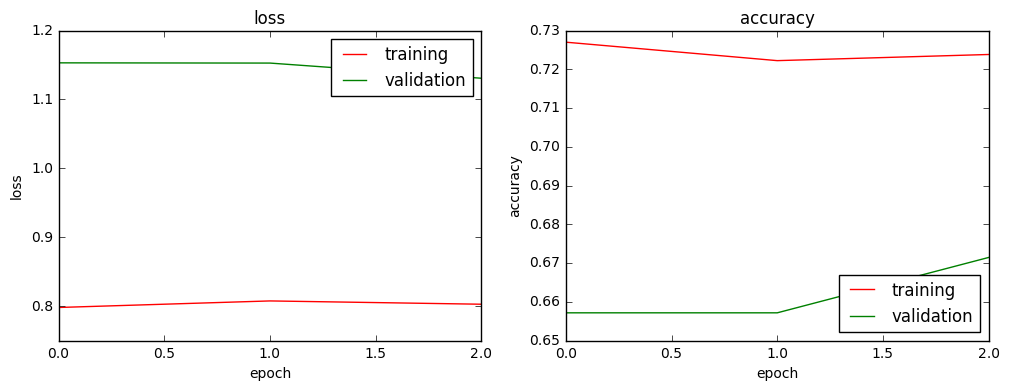

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
ctl_plot = plt.plot(history.history['loss'], 'r', label='training')
cvl_plot = plt.plot(history.history['val_loss'], 'g', label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'r', label='training')
plt.plot(history.history['val_acc'], 'g', label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.legend(loc=4)